## Environment Set up

In [2]:
# usual imports #
import os
import numpy as np
import pandas as pd

# visualization imports #
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

# consistent plots #
from pylab import rcParams
rcParams['figure.figsize']= 12,5
rcParams['xtick.labelsize']= 12
rcParams['ytick.labelsize']= 12
rcParams['axes.labelsize']= 12

# ignore unwanted warnings #
import warnings
warnings.filterwarnings(action='ignore',message='^internal gelsd')

In [3]:
# designate directory to save the images #
ROOT_DIR = '/kaggle/input/day-3-kaggle-competition'


In [4]:
DATA_PATH = os.path.join(ROOT_DIR , 'data_comp/data_comp')
TRAIN_PATH = os.path.join(DATA_PATH,'train')
TEST_PATH = os.path.join(DATA_PATH + '/' + 'test')

In [5]:
# check the files or directories in the training path #
os.listdir(TRAIN_PATH)

['sofa', 'swivelchair', 'bed', 'chair', 'table']

## Data Exploration 
Select any random directory and view one of the images from the training folder

In [6]:
rand = np.random.randint(len(os.listdir(TRAIN_PATH)))
furniture_title = os.listdir(TRAIN_PATH)[rand]

In [7]:
furniture_path = os.path.join(TRAIN_PATH,furniture_title)
furniture_images  = os.listdir(furniture_path)

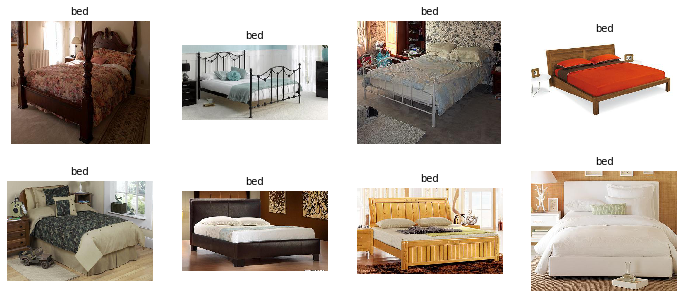

In [8]:
n_rows = 2
n_cols = 4

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows,n_cols,index+1)
        sample_image_path = os.path.join(furniture_path + '/',furniture_images[index])
        furniture = imread(sample_image_path)
        plt.imshow(furniture,cmap='binary',interpolation='nearest')
        plt.axis('off')
        plt.title(furniture_title,fontsize=10)  

Clearly 
- These are colored 3D images of the furnitures
- The same furniture can be presented in any orientation and can have varying size
- The brightness varies etc

Hene the model should be good enough to be able to identify the furniture type 
when it is shown in different angles. 

***Check the number of images in the training folder***

In [9]:
num_images = 0
for folder in os.listdir(TRAIN_PATH):
    num_images = num_images + len(os.listdir(os.path.join(TRAIN_PATH + '/' + folder)))    
print ('Total number of images in the train dir = {}'.format(num_images))

Total number of images in the train dir = 6485


***Check the dimension of these images***
Calculate the mean dimension to set as the input_shape


In [10]:
# check the dimension of each training image and calculate the mean shape #
dim1 = []
dim2 = []

for folder in os.listdir(TRAIN_PATH):
    for image_filename in os.listdir(TRAIN_PATH + '/' + folder):
        img = imread(os.path.join(TRAIN_PATH,folder,image_filename))
        #print(os.path.join(TRAIN_PATH,folder,image_filename))
        d1,d2 = img.shape[0],img.shape[1]
        dim1.append(d1)
        dim2.append(d2)
print (np.mean(dim1),np.mean(dim2))


339.69452582883576 376.853199691596


In [11]:
IMAGE_SHAPE = (int(np.mean(dim1)),int(np.mean(dim2)),3)


In [12]:
# image shape with the color channel to be later fed into the model #
IMAGE_SHAPE

(339, 376, 3)

## Prepare the data for Deep Learning Model 

More than 6000 images is too much data to read all at once in memory. The better strategy would be to use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. 

In [13]:
# import the image data generator 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

***Use the ImageDataGenerator to generate images by using the following parameters***
- rotate_range --> rotate images by 20%
- width_shift_range --> shift the width by 10%
- height_shift_range --> shift the height by 10%
- rescale --> rescale the image to be between 0 and 1 
- shear_range --> cut off by a certain percentage 10%
- zoom_range --> zoom the image by 10%
- horizontal_flip --> flip the image horizontally
- fill_mode --> fill the empty pixel based on the values of the nearest pixel in original image
- vertical_flip --> flip the image vertically (upside down)
- validation_split --> use 30% of the data in training folder for validation

In [14]:
# generate images using the data generator --> check help(ImageDataGenerator) #
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10, 
                               height_shift_range=0.10,
                               rescale=1./255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               vertical_flip=False,
                               validation_split=0.3)  

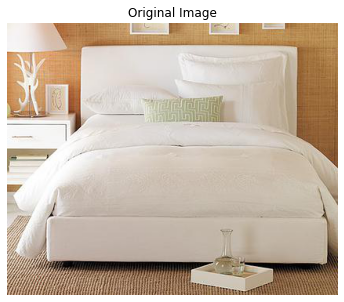

In [15]:
# visualize one of the original image of a furniture #
furniture_orig = imread(sample_image_path)
plt.imshow(furniture_orig)
plt.axis('off')
plt.title('Original Image');

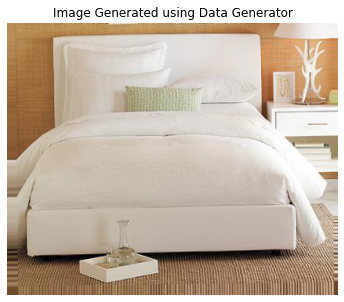

In [16]:
# visualize one the randomly generated image by the image generator of the same fruit #
plt.imshow(image_gen.random_transform(furniture_orig))
plt.axis('off')
plt.title('Image Generated using Data Generator');

### Generating many manipulated images from directory

In [17]:
image_gen.flow_from_directory(TRAIN_PATH)

Found 6485 images belonging to 5 classes.


## Model Creation

***Use combination of Covolutional, Pooling Layer and finally Dense Layer***

In [18]:
# import the libraries #
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D,Dropout
from tensorflow import keras

In [19]:
# clear the session #
keras.backend.clear_session()
np.random.seed(42)

In [20]:
# create a sequential model #
model = Sequential()

# convolutional and max pool layer #
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',strides=(1,1),
                activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',strides=(1,1),
                activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',strides=(1,1),
                activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D(pool_size=(2,2)))

# flatten the layer before feeding into the dense layer #
model.add(Flatten())

# dense layer together with dropout to prevent overfitting #
model.add(Dense(units=128,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(units=64,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(units=32,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.5))

# there are 33 classes, hence 33 neurons in the final layer #
model.add(Dense(units=5,activation='softmax'))

# compile the model #
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
# check the model summary # 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 339, 376, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 169, 188, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 169, 188, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 84, 94, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 84, 94, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 42, 47, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 252672)            0

In [22]:
#model.layers

## Early Stopping

In [23]:
# import early stopping and model checkpoint #
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

## Data for training the Model

In [25]:
BATCH_SIZE = 16
IMAGE_SHAPE[:2]

(339, 376)

***Train Image***

In [26]:
train_image_gen = image_gen.flow_from_directory(TRAIN_PATH,target_size=IMAGE_SHAPE[:2],
                                               color_mode='rgb',batch_size=BATCH_SIZE,
                                               class_mode='categorical',seed=1,subset='training')

Found 4541 images belonging to 5 classes.


***Validation Image***

In [27]:
validation_image_gen = image_gen.flow_from_directory(TRAIN_PATH,target_size=IMAGE_SHAPE[:2],
                                               color_mode='rgb',batch_size=BATCH_SIZE,
                                               class_mode='categorical', shuffle=False,subset='validation',
                                               seed=1)

Found 1944 images belonging to 5 classes.


In [28]:
# check the class indices #
train_image_gen.class_indices

{'bed': 0, 'chair': 1, 'sofa': 2, 'swivelchair': 3, 'table': 4}

## Train the Model

In [29]:
# fit the model and train with early stop enabled #
epoch = 25
history=model.fit(train_image_gen,
                  validation_data = validation_image_gen,
                  epochs = epoch,callbacks=[early_stop])

Epoch 1/25
284/284 [==============================] - 186s 656ms/step - loss: 1.5950 - accuracy: 0.2693 - val_loss: 1.4112 - val_accuracy: 0.3776
Epoch 2/25
284/284 [==============================] - 183s 644ms/step - loss: 1.3623 - accuracy: 0.4296 - val_loss: 1.1109 - val_accuracy: 0.5736
Epoch 3/25
284/284 [==============================] - 185s 652ms/step - loss: 1.1327 - accuracy: 0.5585 - val_loss: 0.9510 - val_accuracy: 0.6487
Epoch 4/25
284/284 [==============================] - 185s 652ms/step - loss: 1.0469 - accuracy: 0.6041 - val_loss: 0.8553 - val_accuracy: 0.6744
Epoch 5/25
284/284 [==============================] - 185s 651ms/step - loss: 0.9399 - accuracy: 0.6589 - val_loss: 0.8785 - val_accuracy: 0.6584
Epoch 6/25
284/284 [==============================] - 185s 652ms/step - loss: 0.8689 - accuracy: 0.6829 - val_loss: 0.7470 - val_accuracy: 0.7279
Epoch 7/25
284/284 [==============================] - 187s 658ms/step - loss: 0.8247 - accuracy: 0.7106 - val_loss: 0.7704 -

In [30]:
model.save('model')

In [31]:
# create dataframe of the loss and accuracy of the train and validation data #
df_loss = pd.DataFrame(model.history.history)
df_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,1.594960,0.269324,1.411203,0.377572
1,1.362348,0.429641,1.110944,0.573560
2,1.132679,0.558467,0.950976,0.648663
3,1.046936,0.604052,0.855263,0.674383
4,0.939927,0.658886,0.878475,0.658436


Text(0, 0.5, 'loss')

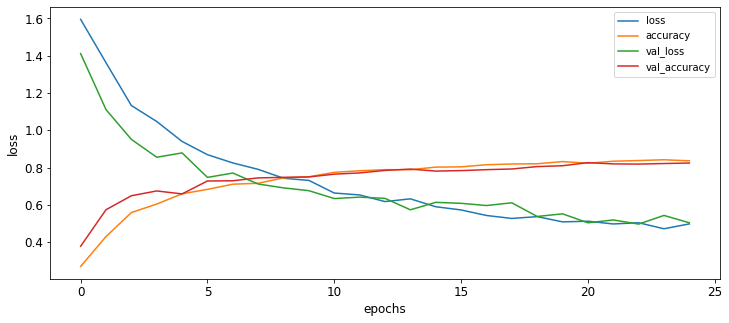

In [32]:
df_loss[['loss','accuracy','val_loss','val_accuracy']].plot()
plt.xlabel('epochs')
plt.ylabel('loss')

In [33]:
model.evaluate(validation_image_gen)

122/122 [==============================] - 56s 460ms/step - loss: 0.4989 - accuracy: 0.8153


[0.4988677501678467, 0.8153291940689087]

In [34]:
test_image_gen = ImageDataGenerator(rescale=1./255)   


In [35]:
os.makedirs('/kaggle/test',exist_ok=True)

In [36]:
from distutils.dir_util import copy_tree

In [37]:
TEST_PATH

'/kaggle/input/day-3-kaggle-competition/data_comp/data_comp/test'

In [38]:
src = TEST_PATH
dest = '/kaggle/test/test'

In [39]:
copy_tree(src,dest)
#test_path = '/kaggle/test'

['/kaggle/test/test/img1194.jpg',
 '/kaggle/test/test/img1493.jpg',
 '/kaggle/test/test/img516.jpg',
 '/kaggle/test/test/img254.jpg',
 '/kaggle/test/test/img263.jpg',
 '/kaggle/test/test/img2015.jpg',
 '/kaggle/test/test/img1738.jpg',
 '/kaggle/test/test/img659.jpg',
 '/kaggle/test/test/img1483.jpg',
 '/kaggle/test/test/img2056.jpg',
 '/kaggle/test/test/img1659.jpg',
 '/kaggle/test/test/img575.jpg',
 '/kaggle/test/test/img1013.jpg',
 '/kaggle/test/test/img0.jpg',
 '/kaggle/test/test/img1119.jpg',
 '/kaggle/test/test/img403.jpg',
 '/kaggle/test/test/img1138.jpg',
 '/kaggle/test/test/img1173.jpg',
 '/kaggle/test/test/img1176.jpg',
 '/kaggle/test/test/img1906.jpg',
 '/kaggle/test/test/img976.jpg',
 '/kaggle/test/test/img224.jpg',
 '/kaggle/test/test/img985.jpg',
 '/kaggle/test/test/img514.jpg',
 '/kaggle/test/test/img1482.jpg',
 '/kaggle/test/test/img170.jpg',
 '/kaggle/test/test/img212.jpg',
 '/kaggle/test/test/img280.jpg',
 '/kaggle/test/test/img1326.jpg',
 '/kaggle/test/test/img77.jpg'

In [40]:
test_path = '/kaggle/test'

In [41]:
test_generator = test_image_gen.flow_from_directory(directory=test_path,
                                                 target_size=IMAGE_SHAPE[:2],
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=None,
                                                  shuffle=False)

Found 2164 images belonging to 1 classes.


In [42]:
pred = model.predict(test_generator,steps=len(test_generator),verbose=1)

136/136 [==============================] - 11s 79ms/step


In [43]:
predicted_class_indices=np.argmax(pred,axis=1)

In [44]:
labels = (train_image_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [45]:
# get filenames 
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [46]:
results

,Filename,Predictions
0,test/img0.jpg,chair
1,test/img1.jpg,swivelchair
2,test/img10.jpg,chair
3,test/img100.jpg,swivelchair
4,test/img1000.jpg,chair
...,...,...
2159,test/img995.jpg,chair
2160,test/img996.jpg,table
2161,test/img997.jpg,sofa
2162,test/img998.jpg,sofa


In [47]:
results.head()

,Filename,Predictions
0,test/img0.jpg,chair
1,test/img1.jpg,swivelchair
2,test/img10.jpg,chair
3,test/img100.jpg,swivelchair
4,test/img1000.jpg,chair


In [48]:
def file_name(st):
    x = st.split('/')
    y = x[1].split('.')
    return y[0]

In [49]:
results['image'] = results['Filename'].apply(file_name)

In [50]:
results.head()

,Filename,Predictions,image
0,test/img0.jpg,chair,img0
1,test/img1.jpg,swivelchair,img1
2,test/img10.jpg,chair,img10
3,test/img100.jpg,swivelchair,img100
4,test/img1000.jpg,chair,img1000


In [51]:
results.drop('Filename',axis=1,inplace=True)

In [52]:
results.head(5)

,Predictions,image
0,chair,img0
1,swivelchair,img1
2,chair,img10
3,swivelchair,img100
4,chair,img1000


In [53]:
def pred(st):
    if st=='chair':
        return 1
    elif st == 'swivelchair':
        return 3
    elif st == 'bed':
        return 0
    elif st == 'table':
        return 4
    else:
        return 2
        
    
    

In [54]:
results['target'] = results['Predictions'].apply(pred)

In [55]:
results.head(100)

,Predictions,image,target
0,chair,img0,1
1,swivelchair,img1,3
2,chair,img10,1
3,swivelchair,img100,3
4,chair,img1000,1
...,...,...,...
95,swivelchair,img1083,3
96,bed,img1084,0
97,swivelchair,img1085,3
98,bed,img1086,0


In [56]:
results.drop('Predictions',axis=1,inplace=True)

In [57]:
results.head(10)

,image,target
0,img0,1
1,img1,3
2,img10,1
3,img100,3
4,img1000,1
5,img1001,3
6,img1002,0
7,img1003,3
8,img1004,4
9,img1005,1


In [58]:
results.to_csv('furn_submission.csv',index=False)

In [59]:
os.listdir('/kaggle/working')

['__notebook__.ipynb', 'model', 'furn_submission.csv']

In [60]:
results.head()

,image,target
0,img0,1
1,img1,3
2,img10,1
3,img100,3
4,img1000,1


In [61]:
type(results['image'][0])

str